In [1]:
# Import, authenticate and initialize the Earth Engine library
import ee
import geemap
ee.Initialize()
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import tensorflow as tf
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import rasterio
from rasterio.transform import from_origin
from rasterio.plot import show
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import math
import pdb
import folium
import pyproj
from shapely.ops import cascaded_union
from shapely.geometry import Polygon, MultiPolygon
import joblib
from sklearn import preprocessing
from scipy import ndimage
from scipy import interpolate
from rasterio.fill import fillnodata
from rasterio.plot import show
import shap

print("tf version", tf. __version__)

2023-07-27 15:48:27.265925: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-27 15:48:27.268669: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-27 15:48:27.321608: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-27 15:48:27.324640: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-27 15:48:28.320686: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

tf version 2.12.0


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Set working directory
os.getcwd()
os.chdir('/home/shoyo/Desktop')

In [3]:
# Set seed
seed = 42
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  os.environ['CUDA_VISIBLE_DEVICES'] = " "
set_seed(42)
tf.config.experimental.enable_op_determinism()

In [90]:
# Define a polygon of interest

geojson = geemap.geojson_to_ee(os.getcwd()+'/kenyan-counties.geojson')
# polygon2 = ee.Geometry.Polygon(geojson)
# polygon = ee.FeatureCollection(polygon)
# polygon1 = ee.Geometry(geojson)

boundary = gpd.read_file(os.getcwd()+'/kenyan-counties.geojson')
# boundary = boundary[boundary.COUNTY=='Nakuru']
boundary = boundary[(boundary.COUNTY=='Nairobi')|(boundary.COUNTY=='Kiambu')]
xmin, ymin, xmax, ymax = boundary.total_bounds
# xmin, ymin, xmax, ymax = boundary.bounds['minx'].min(),boundary.bounds['miny'].min(),boundary.bounds['maxx'].max(),boundary.bounds['maxy'].max()
# xmin, ymin, xmax, ymax = boundary.bounds['minx'].mean(),boundary.bounds['miny'].mean(),boundary.bounds['maxx'].mean(),boundary.bounds['maxy'].mean()
# xmin = (xmax+xmin)/2
# ymin = (ymax+ymin)/2
xmax = (xmax+xmin)/2
xmax = (xmax+xmin)/2
ymax = ymax + (ymax+ymin)*0.25
ymin = ymin - (ymax+ymin)*0.25
polygon = ee.Geometry.Polygon([[xmin,ymin], [xmin,ymax], [xmax,ymax], [xmax,ymin]])

In [91]:
# Visualise the polygon

Map = geemap.Map(center=[xmin,ymin], zoom=10)
Map.centerObject(polygon)
Map.addLayer(polygon, {'color': '00000000'})
print(polygon.bounds().getInfo())
Map

{'geodesic': False, 'type': 'Polygon', 'coordinates': [[[36.48822784384009, -1.3091320523003844], [36.706875800702804, -1.3091320523003844], [36.706875800702804, -0.7557627369981318], [36.48822784384009, -0.7557627369981318], [36.48822784384009, -1.3091320523003844]]]}


Map(center=[36.48822784384009, -0.7557627369981572], controls=(WidgetControl(options=['position', 'transparent…

In [92]:
# Functions for Landsat preprocessing

def cloudMask(image):
  qa = image.select('QA_PIXEL')
  # dilated = 1 << 1, cirrus = 1 << 2, cloud = 1 << 3, shadow = 1 << 4
  mask = ((qa.bitwise_and(1 << 3).neq(0)).multiply(1)
      .add((qa.bitwise_and(1 << 4).neq(0)).multiply(1))
      .add((qa.bitwise_and(1 << 2).neq(0)).multiply(1))
      # .add((qa.bitwise_and(1 << 1).neq(0)).multiply(1))
      )
  return image.updateMask(mask)

def addEVI(image):
  SR = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  image = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  image = image.addBands(SR, None, True)
  evi = image.expression( '2.5 * ( (NIR-RED) / (NIR + 6*RED - 7.5*BLUE + 1))', {
      'NIR': image.select('SR_B5'),
      'RED': image.select('SR_B4'),
      'BLUE': image.select('SR_B2'),
      }).rename('EVI')
  return image.addBands(evi)

In [93]:
# Functions for Sentinel-1 preprocessing

# Linear to db scale
def lin_to_db(image):
    bandNames = image.bandNames().remove('angle')
    db = ee.Image.constant(10).multiply(image.select(bandNames).log10()).rename(bandNames)
    return image.addBands(db, None, True)

def db_to_lin(image):
    bandNames = image.bandNames().remove('angle')
    lin = ee.Image.constant(10).pow(image.select(bandNames).divide(10)).rename(bandNames)
    return image.addBands(lin, None, True)

def lin_to_db2(image):
    db = ee.Image.constant(10).multiply(image.select(['VV', 'VH']).log10()).rename(['VV', 'VH'])
    return image.addBands(db, None, True)

# Add ratio bands
def add_ratio_lin(image):
    ratio = image.addBands(image.select('VV').divide(image.select('VH')).rename('VVVH_ratio'))
    
    return ratio.set('system:time_start', image.get('system:time_start'))

# Additional Border Noise Removal
def maskAngLT452(image):
    ang = image.select(['angle'])
    return image.updateMask(ang.lt(45.23993)).set('system:time_start', image.get('system:time_start'))

def maskAngGT30(image):
    ang = image.select(['angle'])
    return image.updateMask(ang.gt(30.63993)).set('system:time_start', image.get('system:time_start'))

def maskEdge(image):
    mask = image.select(0).unitScale(-25, 5).multiply(255).toByte()#.connectedComponents(ee.Kernel.rectangle(1,1), 100)
    return image.updateMask(mask.select(0)).set('system:time_start', image.get('system:time_start')) 

def f_mask_edges(image):
    db_img = lin_to_db(image)
    output = maskAngGT30(db_img)
    output = maskAngLT452(output)
    #output = maskEdge(output)
    output = db_to_lin(output)
    return output.set('system:time_start', image.get('system:time_start'))

# 1.SPECKLE FILTERS
def boxcar(image, KERNEL_SIZE):
    bandNames = image.bandNames().remove('angle')
      #Define a boxcar kernel
    kernel = ee.Kernel.square((KERNEL_SIZE/2), units='pixels', normalize=True)
     #Apply boxcar
    output = image.select(bandNames).convolve(kernel).rename(bandNames)
    return image.addBands(output, None, True)

def RefinedLee(image):
    """
    This filter is modified from the implementation by Guido Lemoine 
    Source: Lemoine et al. https://code.earthengine.google.com/5d1ed0a0f0417f098fdfd2fa137c3d0c
    """
    bandNames = image.bandNames().remove('angle')
    def inner(b):

        img = image.select([b]);
    
        # img must be linear, i.e. not in dB!
        # Set up 3x3 kernels 
        weights3 = ee.List.repeat(ee.List.repeat(1,3),3);
        kernel3 = ee.Kernel.fixed(3,3, weights3, 1, 1, False);
  
        mean3 = img.reduceNeighborhood(ee.Reducer.mean(), kernel3);
        variance3 = img.reduceNeighborhood(ee.Reducer.variance(), kernel3);
  
        # Use a sample of the 3x3 windows inside a 7x7 windows to determine gradients and directions
        sample_weights = ee.List([[0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0], [0,1,0,1,0,1,0], [0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0]]);
  
        sample_kernel = ee.Kernel.fixed(7,7, sample_weights, 3,3, False);
  
        # Calculate mean and variance for the sampled windows and store as 9 bands
        sample_mean = mean3.neighborhoodToBands(sample_kernel); 
        sample_var = variance3.neighborhoodToBands(sample_kernel);
  
        # Determine the 4 gradients for the sampled windows
        gradients = sample_mean.select(1).subtract(sample_mean.select(7)).abs();
        gradients = gradients.addBands(sample_mean.select(6).subtract(sample_mean.select(2)).abs());
        gradients = gradients.addBands(sample_mean.select(3).subtract(sample_mean.select(5)).abs());
        gradients = gradients.addBands(sample_mean.select(0).subtract(sample_mean.select(8)).abs());
  
        # And find the maximum gradient amongst gradient bands
        max_gradient = gradients.reduce(ee.Reducer.max());
  
        # Create a mask for band pixels that are the maximum gradient
        gradmask = gradients.eq(max_gradient);
  
        # duplicate gradmask bands: each gradient represents 2 directions
        gradmask = gradmask.addBands(gradmask);
  
        # Determine the 8 directions
        directions = sample_mean.select(1).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(7))).multiply(1);
        directions = directions.addBands(sample_mean.select(6).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(2))).multiply(2));
        directions = directions.addBands(sample_mean.select(3).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(5))).multiply(3));
        directions = directions.addBands(sample_mean.select(0).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(8))).multiply(4));
        # The next 4 are the not() of the previous 4
        directions = directions.addBands(directions.select(0).Not().multiply(5));
        directions = directions.addBands(directions.select(1).Not().multiply(6));
        directions = directions.addBands(directions.select(2).Not().multiply(7));
        directions = directions.addBands(directions.select(3).Not().multiply(8));
  
        # Mask all values that are not 1-8
        directions = directions.updateMask(gradmask);
  
        # "collapse" the stack into a singe band image (due to masking, each pixel has just one value (1-8) in it's directional band, and is otherwise masked)
        directions = directions.reduce(ee.Reducer.sum());  
  
        sample_stats = sample_var.divide(sample_mean.multiply(sample_mean));
  
        #Calculate localNoiseVariance
        sigmaV = sample_stats.toArray().arraySort().arraySlice(0,0,5).arrayReduce(ee.Reducer.mean(), [0]);
  
        # Set up the 7*7 kernels for directional statistics
        rect_weights = ee.List.repeat(ee.List.repeat(0,7),3).cat(ee.List.repeat(ee.List.repeat(1,7),4));
  
        diag_weights = ee.List([[1,0,0,0,0,0,0], [1,1,0,0,0,0,0], [1,1,1,0,0,0,0], [1,1,1,1,0,0,0], [1,1,1,1,1,0,0], [1,1,1,1,1,1,0], [1,1,1,1,1,1,1]]);
  
        rect_kernel = ee.Kernel.fixed(7,7, rect_weights, 3, 3, False);
        diag_kernel = ee.Kernel.fixed(7,7, diag_weights, 3, 3, False);
  
        # Create stacks for mean and variance using the original kernels. Mask with relevant direction.
        dir_mean = img.reduceNeighborhood(ee.Reducer.mean(), rect_kernel).updateMask(directions.eq(1));
        dir_var = img.reduceNeighborhood(ee.Reducer.variance(), rect_kernel).updateMask(directions.eq(1));
  
        dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(), diag_kernel).updateMask(directions.eq(2)));
        dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(), diag_kernel).updateMask(directions.eq(2)));
  
        # and add the bands for rotated kernels
        for i in range(1, 4):
            dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
            dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
            dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))
            dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))

  
        # "collapse" the stack into a single band image (due to masking, each pixel has just one value in it's directional band, and is otherwise masked)
        dir_mean = dir_mean.reduce(ee.Reducer.sum());
        dir_var = dir_var.reduce(ee.Reducer.sum());
  
        # A finally generate the filtered value
        varX = dir_var.subtract(dir_mean.multiply(dir_mean).multiply(sigmaV)).divide(sigmaV.add(1.0))
  
        b = varX.divide(dir_var)
        result = dir_mean.add(b.multiply(img.subtract(dir_mean)))
  
        return result.arrayProject([0]).arrayFlatten([['sum']]).float()
    
    result = ee.ImageCollection(bandNames.map(inner)).toBands().rename(bandNames).copyProperties(image)
    
    return image.addBands(result, None, True) 


# 2. MONO-TEMPORAL SPECKLE FILTER (WRAPPER)
def MonoTemporal_Filter(coll,KERNEL_SIZE, SPECKLE_FILTER) :
    def _filter(image):    
      #  if (SPECKLE_FILTER=='BOXCAR'):
      #     _filtered = boxcar(image, KERNEL_SIZE)
      #  elif (SPECKLE_FILTER=='LEE'):
      #     _filtered = leefilter(image, KERNEL_SIZE)
      #  elif (SPECKLE_FILTER=='GAMMA MAP'):
      #     _filtered = gammamap(image, KERNEL_SIZE)
       if (SPECKLE_FILTER=='REFINED LEE'):
          _filtered = RefinedLee(image)
      #  elif (SPECKLE_FILTER=='LEE SIGMA'):
      #     _filtered = leesigma(image, KERNEL_SIZE)
      #  return _filtered
    return coll.map(_filter)


# 3. MULTI-TEMPORAL SPECKLE FILTER
def MultiTemporal_Filter(coll,KERNEL_SIZE, SPECKLE_FILTER,NR_OF_IMAGES):
    def Quegan(image) :
        """
        The following Multi-temporal speckle filters are implemented as described in
        S. Quegan and J. J. Yu, “Filtering of multichannel SAR images,” 
        IEEE Trans Geosci. Remote Sensing, vol. 39, Nov. 2001.
        """
        def setresample(image):
                return image.resample()
            
        def get_filtered_collection(image):  
            #filter collection over are and by relative orbit
            s1_coll = ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') \
                .filterBounds(image.geometry()) \
                .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', ee.List(image.get('transmitterReceiverPolarisation')).get(-1))) \
                .filter(ee.Filter.Or(ee.Filter.eq('relativeOrbitNumber_stop', image.get('relativeOrbitNumber_stop')), \
                                     ee.Filter.eq('relativeOrbitNumber_stop', image.get('relativeOrbitNumber_start'))
                )).map(setresample)
      
            #a function that takes the image and checks for the overlap
            def check_overlap(_image):
                # get all S1 frames from this date intersecting with the image bounds
                s1 = s1_coll.filterDate(_image.date(), _image.date().advance(1, 'day'))
                # intersect those images with the image to filter
                intersect = image.geometry().intersection(s1.geometry().dissolve(), 10)
                # check if intersect is sufficient
                valid_date = ee.Algorithms.If(intersect.area(10).divide(image.geometry().area(10)).gt(0.95), \
                                              _image.date().format('YYYY-MM-dd')
                                              )
                return ee.Feature(None, {'date': valid_date})
      
      
            # this function will pick up the acq dates for fully overlapping acquisitions before the image acquistion
            dates_before = s1_coll.filterDate('2014-01-01', image.date().advance(1, 'day')) \
                                    .sort('system:time_start', False).limit(5*NR_OF_IMAGES) \
                                    .map(check_overlap).distinct('date').aggregate_array('date')
    
            # if the images before are not enough, we add images from after the image acquisition 
            # this will only be the case at the beginning of S1 mission
            dates = ee.List(ee.Algorithms.If( \
                                             dates_before.size().gte(NR_OF_IMAGES), \
                                                 dates_before.slice(0, NR_OF_IMAGES), \
                                                     s1_coll \
                                                         .filterDate(image.date(), '2100-01-01') \
                                                             .sort('system:time_start', True).limit(5*NR_OF_IMAGES) \
                                                                 .map(check_overlap) \
                                                                     .distinct('date') \
                                                                         .aggregate_array('date') \
                                                                             .cat(dates_before).distinct().sort().slice(0, NR_OF_IMAGES)
                                                                             )
                                                )
    
            #now we re-filter the collection to get the right acquisitions for multi-temporal filtering
            return ee.ImageCollection(dates.map(lambda date: s1_coll.filterDate(date, ee.Date(date).advance(1,'day')).toList(s1_coll.size())).flatten())
      
          
  
        #we get our dedicated image collection for that image
        s1 = get_filtered_collection(image)
  
        bands = image.bandNames().remove('angle')
        s1 = s1.select(bands)
        meanBands = bands.map(lambda bandName: ee.String(bandName).cat('_mean'))
        ratioBands = bands.map(lambda bandName: ee.String(bandName).cat('_ratio'))
        count_img = s1.reduce(ee.Reducer.count())

        def inner(image):
            if (SPECKLE_FILTER=='REFINED LEE'):
                _filtered = RefinedLee(image).select(bands).rename(meanBands)    
            _ratio = image.select(bands).divide(_filtered).rename(ratioBands) 
            return _filtered.addBands(_ratio)

        isum = s1.map(inner).select(ratioBands).reduce(ee.Reducer.sum())
        filtered = inner(image).select(meanBands)
        divide = filtered.divide(count_img)
        output = divide.multiply(isum).rename(bands)

        return image.addBands(output, None, True)
    return coll.map(Quegan)

# Terrain Flattening
def slope_correction(collection, TERRAIN_FLATTENING_MODEL, DEM, TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER):
    ninetyRad = ee.Image.constant(90).multiply(math.pi/180)

    def _volumetric_model_SCF(theta_iRad, alpha_rRad):
        # Volume model
        nominator = (ninetyRad.subtract(theta_iRad).add(alpha_rRad)).tan()
        denominator = (ninetyRad.subtract(theta_iRad)).tan()
        return nominator.divide(denominator)

    def _direct_model_SCF(theta_iRad, alpha_rRad, alpha_azRad):
        # Surface model
        nominator = (ninetyRad.subtract(theta_iRad)).cos()
        denominator = alpha_azRad.cos().multiply((ninetyRad.subtract(theta_iRad).add(alpha_rRad)).cos())
        return nominator.divide(denominator)

    def _erode(image, distance):
        # buffer function (thanks Noel)
        d = (image.Not().unmask(1).fastDistanceTransform(30).sqrt()
             .multiply(ee.Image.pixelArea().sqrt()))
        return image.updateMask(d.gt(distance))

    def _masking(alpha_rRad, theta_iRad, buffer):
        # calculate masks
        # layover, where slope > radar viewing angle
        layover = alpha_rRad.lt(theta_iRad).rename('layover')
        # shadow
        shadow = alpha_rRad.gt(ee.Image.constant(-1)
                        .multiply(ninetyRad.subtract(theta_iRad))).rename('shadow')
        # combine layover and shadow
        mask = layover.And(shadow)
        # add buffer to final mask
        if (buffer > 0):
            mask = _erode(mask, buffer)
        return mask.rename('no_data_mask')

    def _correct(image):
        bandNames = image.bandNames()
        geom = image.geometry()
        proj = image.select(1).projection()
        elevation = DEM.resample('bilinear').reproject(proj,None, 10).clip(geom)
        # calculate the look direction
        heading = ee.Terrain.aspect(image.select('angle')).reduceRegion(ee.Reducer.mean(), image.geometry(), 1000)
        
        #in case of null values for heading replace with 0
        heading = ee.Dictionary(heading).combine({'aspect': 0}, False).get('aspect')
        
        heading = ee.Algorithms.If(
            ee.Number(heading).gt(180),
            ee.Number(heading).subtract(360),
            ee.Number(heading)
        )
        
        # the numbering follows the article chapters
        # 2.1.1 Radar geometry
        theta_iRad = image.select('angle').multiply(math.pi/180)
        phi_iRad = ee.Image.constant(heading).multiply(math.pi/180)
        
        # 2.1.2 Terrain geometry
        alpha_sRad = ee.Terrain.slope(elevation).select('slope').multiply(math.pi / 180)

        aspect = ee.Terrain.aspect(elevation).select('aspect').clip(geom)
        
        aspect_minus = aspect.updateMask(aspect.gt(180)).subtract(360)
        
        phi_sRad = aspect.updateMask(aspect.lte(180))\
            .unmask()\
            .add(aspect_minus.unmask())\
            .multiply(-1)\
            .multiply(math.pi / 180)
          
        #elevation = DEM.reproject(proj,None, 10).clip(geom)

        # 2.1.3 Model geometry
        # reduce to 3 angle
        phi_rRad = phi_iRad.subtract(phi_sRad)

        # slope steepness in range (eq. 2)
        alpha_rRad = (alpha_sRad.tan().multiply(phi_rRad.cos())).atan()

        # slope steepness in azimuth (eq 3)
        alpha_azRad = (alpha_sRad.tan().multiply(phi_rRad.sin())).atan()

        # 2.2
        # Gamma_nought
        gamma0 = image.divide(theta_iRad.cos())

        if (TERRAIN_FLATTENING_MODEL == 'VOLUME'):
            # Volumetric Model
            scf = _volumetric_model_SCF(theta_iRad, alpha_rRad)

        if (TERRAIN_FLATTENING_MODEL == 'DIRECT'):
            scf = _direct_model_SCF(theta_iRad, alpha_rRad, alpha_azRad)

        # apply model for Gamm0
        gamma0_flat = gamma0.multiply(scf)

        # get Layover/Shadow mask
        mask = _masking(alpha_rRad, theta_iRad, TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER)
        output = gamma0_flat.mask(mask).rename(bandNames).copyProperties(image)
        output = ee.Image(output).addBands(image.select('angle'), None, True)

        return output.set('system:time_start', image.get('system:time_start'))
    return collection.map(_correct)

def addRatio(image):

  ratio = image.expression( 'VV / VH', {
      'VV': image.select('VV'),
      'VH': image.select('VH'),
      }).rename('VV/VH')
  return image.addBands(ratio)

def s1_preproc(params):
    APPLY_BORDER_NOISE_CORRECTION = params['APPLY_BORDER_NOISE_CORRECTION']
    APPLY_TERRAIN_FLATTENING = params['APPLY_TERRAIN_FLATTENING']
    APPLY_SPECKLE_FILTERING = params['APPLY_SPECKLE_FILTERING']
    POLARIZATION = params['POLARIZATION']
    # PLATFORM_NUMBER = params['PLATFORM_NUMBER']
    ORBIT = params['ORBIT']
    # ORBIT_NUM = params['ORBIT_NUM']
    SPECKLE_FILTER_FRAMEWORK = params['SPECKLE_FILTER_FRAMEWORK']
    SPECKLE_FILTER = params['SPECKLE_FILTER']
    SPECKLE_FILTER_KERNEL_SIZE = params['SPECKLE_FILTER_KERNEL_SIZE']
    SPECKLE_FILTER_NR_OF_IMAGES = params['SPECKLE_FILTER_NR_OF_IMAGES']
    TERRAIN_FLATTENING_MODEL = params['TERRAIN_FLATTENING_MODEL']
    DEM = params['DEM']
    TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER = params['TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER']
    FORMAT = params['FORMAT']
    START_DATE = params['START_DATE']
    STOP_DATE = params['STOP_DATE']
    ROI = params['ROI']
    CLIP_TO_ROI = params['CLIP_TO_ROI']
    SAVE_ASSET = params['SAVE_ASSET']
    # ASSET_ID = params['ASSET_ID']

    # 0. CHECK PARAMETERS
    if APPLY_BORDER_NOISE_CORRECTION is None:
        APPLY_BORDER_NOISE_CORRECTION = True
    if APPLY_TERRAIN_FLATTENING is None:
        APPLY_TERRAIN_FLATTENING = True
    if APPLY_SPECKLE_FILTERING is None:
        APPLY_SPECKLE_FILTERING = True
    if POLARIZATION is None:
        POLARIZATION = 'VVVH'
    if ORBIT is None:
        ORBIT = 'BOTH'
    if SPECKLE_FILTER_FRAMEWORK is None:
        SPECKLE_FILTER_FRAMEWORK = 'MULTI'
    if SPECKLE_FILTER is None:
        SPECKLE_FILTER = 'REFINED LEE'
    if SPECKLE_FILTER_KERNEL_SIZE is None:
        SPECKLE_FILTER_KERNEL_SIZE = 7
    if SPECKLE_FILTER_NR_OF_IMAGES is None:
        SPECKLE_FILTER_NR_OF_IMAGES = 10
    if TERRAIN_FLATTENING_MODEL is None:
        TERRAIN_FLATTENING_MODEL = 'VOLUME'
    if TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER is None:
        TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER = 0
    if FORMAT is None:
        FORMAT = 'DB'
    # if ORBIT is None:
    #     ORBIT = 'DESCENDING'

    pol_required = ['VV', 'VH', 'VVVH']
    if (POLARIZATION not in pol_required):
        raise ValueError("ERROR!!! Parameter POLARIZATION not correctly defined")

    orbit_required = ['ASCENDING', 'DESCENDING', 'BOTH']
    if (ORBIT not in orbit_required):
        raise ValueError("ERROR!!! Parameter ORBIT not correctly defined")

    model_required = ['DIRECT', 'VOLUME']
    if (TERRAIN_FLATTENING_MODEL not in model_required):
        raise ValueError("ERROR!!! Parameter TERRAIN_FLATTENING_MODEL not correctly defined")

    format_required = ['LINEAR', 'DB']
    if (FORMAT not in format_required):
        raise ValueError("ERROR!!! FORMAT not correctly defined")

    frame_needed = ['MONO', 'MULTI']
    if (SPECKLE_FILTER_FRAMEWORK not in frame_needed):
        raise ValueError("ERROR!!! SPECKLE_FILTER_FRAMEWORK not correctly defined")

    format_sfilter = ['BOXCAR', 'LEE', 'GAMMA MAP'
              ,'REFINED LEE', 'LEE SIGMA']
    
    if (SPECKLE_FILTER not in format_sfilter):
        raise ValueError("ERROR!!! SPECKLE_FILTER not correctly defined")

    if (TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER < 0):
        raise ValueError("ERROR!!! TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER not correctly defined")

    if (SPECKLE_FILTER_KERNEL_SIZE <= 0):
        raise ValueError("ERROR!!! SPECKLE_FILTER_KERNEL_SIZE not correctly defined")


    # 1. DATA SELECTION
    # select S-1 image collection
    s1 = ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')\
        .filter(ee.Filter.eq('instrumentMode', 'IW'))\
        .filter(ee.Filter.eq('resolution_meters', 10)) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
        .filterDate(START_DATE, STOP_DATE) \
        .filterBounds(ROI)

    # select orbit
    if (ORBIT != 'BOTH'):
        s1 = s1.filter(ee.Filter.eq('orbitProperties_pass', ORBIT))

    # select polarization
    if (POLARIZATION == 'VV'):
        s1 = s1.select(['VV', 'angle'])
    elif (POLARIZATION == 'VH'):
        s1 = s1.select(['VH', 'angle'])
    elif (POLARIZATION == 'VVVH'):
        s1 = s1.select(['VV', 'VH', 'angle'])
        
    print('Number of images in collection: ', s1.size().getInfo())

    # 2. ADDITIONAL BORDER NOISE CORRECTION
    if (APPLY_BORDER_NOISE_CORRECTION):
        s1_1 = s1.map(f_mask_edges)
        print('Additional border noise correction is completed')
    else:
        s1_1 = s1

    # 3. SPECKLE FILTERING
    if (APPLY_SPECKLE_FILTERING):
        if (SPECKLE_FILTER_FRAMEWORK == 'MONO'):
            s1_1 = ee.ImageCollection(MonoTemporal_Filter(s1_1, SPECKLE_FILTER_KERNEL_SIZE, SPECKLE_FILTER))
            print('Mono-temporal speckle filtering is completed')
        else:
            s1_1 = ee.ImageCollection(MultiTemporal_Filter(s1_1, SPECKLE_FILTER_KERNEL_SIZE, SPECKLE_FILTER, SPECKLE_FILTER_NR_OF_IMAGES))
            print('Multi-temporal speckle filtering is completed')

    # 4. TERRAIN CORRECTION
    if (APPLY_TERRAIN_FLATTENING):
        s1_1 = (slope_correction(s1_1, TERRAIN_FLATTENING_MODEL ,DEM, TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER))
        print('Radiometric terrain normalization is completed')

    # 5. OUTPUT
    if (FORMAT == 'DB'):
        s1_1 = s1_1.map(lin_to_db)
              
    #clip to roi
    if (CLIP_TO_ROI):
        s1_1 = s1_1.map(lambda image: image.clip(ROI))
        
    return s1_1.map(addRatio).median().clip(ROI)

In [47]:
# Functions to obtain Landsat 8 & 9, Sentinel-1, climate and topography data 

def get_landsat(start, end):
  landsat8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterDate(start, end).filterBounds(polygon).map(cloudMask).map(addEVI).select(['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'EVI'])
  landsat9 = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2").filterDate(start, end).filterBounds(polygon).map(cloudMask).map(addEVI).select(['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'EVI'])
  landsat = landsat8.merge(landsat9).median().clip(polygon)
  return landsat

def getSAR(start, end):
    parameter = {'START_DATE': start,
                'STOP_DATE': end,        
                'POLARIZATION': 'VVVH',
                'ORBIT' : 'BOTH',
                # 'ORBIT_NUM': None,
                'ROI': polygon,
                'APPLY_BORDER_NOISE_CORRECTION': True,
                'APPLY_SPECKLE_FILTERING': True,
                'SPECKLE_FILTER_FRAMEWORK': 'MULTI',
                'SPECKLE_FILTER': 'REFINED LEE',
                'SPECKLE_FILTER_KERNEL_SIZE': 9,
                'SPECKLE_FILTER_NR_OF_IMAGES':10,
                'APPLY_TERRAIN_FLATTENING': True,
                'DEM': ee.Image('USGS/SRTMGL1_003'),
                'TERRAIN_FLATTENING_MODEL': 'VOLUME',
                'TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER':0,
                'FORMAT': 'LINEAR',
                'CLIP_TO_ROI': False,
                'SAVE_ASSET': False,
                # 'ASSET_ID': 
                }
    #processed s1 collection
    s1_processed = s1_preproc(parameter)
    return s1_processed

def getElev():
  elev = ee.Image("USGS/SRTMGL1_003").select(['elevation']).clip(polygon)
  slop = ee.Terrain.slope(elev).clip(polygon)
  return ee.Image.cat([elev.rename('elev'), slop.rename('slope')])

def getTopo():
  aspect = ee.ImageCollection("projects/sat-io/open-datasets/Geomorpho90m/aspect").filterBounds(polygon).median().clip(polygon)
  roughness = ee.ImageCollection("projects/sat-io/open-datasets/Geomorpho90m/roughness").filterBounds(polygon).median().clip(polygon)
  twi = ee.ImageCollection("projects/sat-io/open-datasets/Geomorpho90m/cti").filterBounds(polygon).median().clip(polygon)
  return ee.Image.cat([aspect.rename('aspect'), roughness.rename('rough'), twi.rename('twi')])

def getPrecip(start, end):
  rain = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD").select(['precipitation']).filterDate(start, end).filterBounds(polygon).mean().clip(polygon)
  temp = ee.ImageCollection("MODIS/061/MOD11A1").select(['LST_Day_1km']).filterDate(start, end).filterBounds(polygon).mean().clip(polygon).multiply(0.02)
  return ee.Image.cat([rain.rename('prec'), temp.rename('temp')])

In [18]:
# # Normalize the image
# def normalize(image):
#     bandNames = image.bandNames();
#     #Compute min and max of the image
#     minDict = image.reduceRegion(
#     reducer= ee.Reducer.min(),
#     geometry= image.geometry(),
#     maxPixels= 1e13,
#     bestEffort= True,
#     tileScale= 16,
#     scale=image.projection().nominalScale().getInfo())

#     maxDict = image.reduceRegion(
#     reducer= ee.Reducer.max(),
#     geometry= image.geometry(),
#     maxPixels= 1e13,
#     bestEffort= True,
#     tileScale= 16,
#     scale=image.projection().nominalScale().getInfo())

#     mins = ee.Image.constant(minDict.values(bandNames));
#     maxs = ee.Image.constant(maxDict.values(bandNames));
#     normalized = image.subtract(mins).divide(maxs.subtract(mins))
#     return normalized

In [100]:
# Create a raster stack of necessary features
start = ee.Date('2021-01-01')
end = ee.Date('2021-06-30')
crs = getSAR(start, end).projection().getInfo()['crs']
rasterStack = ee.Image.cat([
    getElev(),
    getTopo(),

    # get_landsat(start.advance(0,'month'), end.advance(0,'month')),
    # getSAR(start.advance(0,'month'), end.advance(0,'month')).select('VV'),
    # getSAR(start.advance(0,'month'), end.advance(0,'month')).select('VH'),
    # getSAR(start.advance(0,'month'), end.advance(0,'month')).select('VV/VH'),
    # getPrecip(start.advance(0,'month'), end.advance(0,'month')),

    # get_landsat(start.advance(6,'month'), end.advance(6,'month')),
    # getSAR(start.advance(6,'month'), end.advance(6,'month')).select('VV'),
    # getSAR(start.advance(6,'month'), end.advance(6,'month')).select('VH'),
    # getSAR(start.advance(6,'month'), end.advance(6,'month')).select('VV/VH'),
    # getPrecip(start.advance(6,'month'), end.advance(6, 'month')),

    # get_landsat(start.advance(12,'month'), end.advance(12,'month')),
    # getSAR(start.advance(12,'month'), end.advance(12,'month')).select('VV'),
    # getSAR(start.advance(12, 'month'), end.advance(12,'month')).select('VH'),
    # getSAR(start.advance(12,'month'), end.advance(12,'month')).select('VV/VH'),
    # getPrecip(start.advance(12,'month'), end.advance(12,'month')),

    get_landsat(start.advance(18,'month'), end.advance(18,'month')),
    getSAR(start.advance(18,'month'), end.advance(18,'month')).select('VV'),
    getSAR(start.advance(18,'month'), end.advance(18,'month')).select('VH'),
    getSAR(start.advance(18,'month'), end.advance(18,'month')).select('VV/VH'),
    getPrecip(start.advance(18,'month'), end.advance(18,'month')),

]).float().reproject(crs=crs, scale=30).resample('bicubic')
# rasterStack = normalize(rasterStack)

Number of images in collection:  72
Additional border noise correction is completed
Multi-temporal speckle filtering is completed
Radiometric terrain normalization is completed
Number of images in collection:  56
Additional border noise correction is completed
Multi-temporal speckle filtering is completed
Radiometric terrain normalization is completed
Number of images in collection:  56
Additional border noise correction is completed
Multi-temporal speckle filtering is completed
Radiometric terrain normalization is completed
Number of images in collection:  56
Additional border noise correction is completed
Multi-temporal speckle filtering is completed
Radiometric terrain normalization is completed


In [101]:
# Save the raster stack in the Google Drive
task = ee.batch.Export.image.toDrive(
            image = rasterStack,
            folder = 'ICRAFinternship',
            description = 'rasterStackNairobi712-2',
            scale = 30,
            crs = rasterStack.projection().getInfo()['crs'],
            region = polygon,
            fileFormat = 'GeoTIFF',
            # filePerBand = False
            # maxPixels = 10063020630
            # selectors = rasterStack.bandNames().getInfo()
            )
  
task.start()

In [89]:
# Check if the task status
task.status()

{'state': 'READY',
 'description': 'rasterStackNairobi16',
 'creation_timestamp_ms': 1690712201747,
 'update_timestamp_ms': 1690712201747,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'JW5EZXGP56OVMM75X4VRNHJA',
 'name': 'projects/earthengine-legacy/operations/JW5EZXGP56OVMM75X4VRNHJA'}

In [ ]:
# Load the prediction models 
rf = joblib.load(os.getcwd() + '/RF2y.pkl')
lstm = tf.keras.models.load_model(os.getcwd() + '/LSTM2y') 

In [102]:
# Load the raster stacks
src3 = rasterio.open(os.getcwd() + '/rasterStackNairobi16.tif')
src2 = rasterio.open(os.getcwd() + '/rasterStackNairobi712.tif')
src1 = rasterio.open(os.getcwd() + '/rasterStackNairobi16-2.tif')
src0 = rasterio.open(os.getcwd() + '/rasterStackNairobi712-2.tif')

array3 = src3.read()
array2 = src2.read()
array1 = src1.read()
array0 = src0.read()

array3norm = src3.read()
array2norm = src2.read()
array1norm = src1.read()
array0norm = src0.read()

In [ ]:
# for index, array in enumerate([array4, array3, array2, array1, array0]):
#     arraynorm = [array4norm, array3norm, array2norm, array1norm, array0norm][index]
#     for i in range(len(array)):
#         valid_indices = np.where(~np.isnan(array[i]))[0]
#         valid_values = array[i][valid_indices]
#         interp_indices = np.arange(len(array[i]))
#         interp_func = interpolate.interp1d(valid_indices, valid_values, kind='nearest', bounds_error=False, fill_value='extrapolate')
#         interpolated_values = interp_func(interp_indices)
#         array[i][np.isnan(array[i])] = interpolated_values[np.isnan(array[i])]

In [103]:
# Nearest neighboutr interpolation to fill NaN data

for index, array in enumerate([array3, array2, array1, array0]):
    arraynorm = [array3norm, array2norm, array1norm, array0norm][index]
    num_bands, num_rows, num_cols = array.shape

    for i in range(len(array)):

        # Get the band array
        band_array = array[i]

        # Create a mask for NaN values
        mask = np.isnan(band_array)

        # Get the valid indices
        valid_indices = np.argwhere(~mask)

        # Get the valid values
        valid_values = band_array[~mask]

        # Create interpolator
        interpolator = scipy.interpolate.NearestNDInterpolator(valid_indices, valid_values)

        # Get the NaN indices
        nan_indices = np.argwhere(mask)

        # Interpolate NaN values
        interpolated_values = interpolator(nan_indices)

        # Assign interpolated values back to the band
        band_array[mask] = interpolated_values

        # Update the band in the original array
        array[i] = band_array

        # # Flatten the band to 1D array
        # flat_band = array[i].flatten()

        # # Find the indices of valid and NaN values
        # valid_indices = np.where(~np.isnan(flat_band))[0]
        # nan_indices = np.where(np.isnan(flat_band))[0]

        # # Extract valid values
        # valid_values = flat_band[valid_indices]

        # # Create interpolator
        # interpolator = scipy.interpolate.NearestNDInterpolator(valid_indices, valid_values)

        # # Interpolate NaN values
        # interpolated_values = interpolator(nan_indices)

        # # Assign interpolated values back to the band
        # flat_band[nan_indices] = interpolated_values

        # # Reshape the band back to original shape
        # array[i] = flat_band.reshape((num_rows, num_cols))

        arraynorm[i] = MinMaxScaler().fit_transform(array[i])

    [array3, array2, array1, array0][index] = array
    [array3norm, array2norm, array1norm, array0norm][index] = arraynorm

In [28]:
# array4 = np.moveaxis(array4, 0, -1)
# array3 = np.moveaxis(array3, 0, -1)
# array2 = np.moveaxis(array2, 0, -1)
# array1 = np.moveaxis(array1, 0, -1)
# array0 = np.moveaxis(array0, 0, -1)

# array4norm = np.moveaxis(array4norm, 0, -1)
# array3norm = np.moveaxis(array3norm, 0, -1)
# array2norm = np.moveaxis(array2norm, 0, -1)
# array1norm = np.moveaxis(array1norm, 0, -1)
# array0norm = np.moveaxis(array0norm, 0, -1)

In [ ]:
# for index, array in enumerate([array4, array3, array2, array1, array0]):
#     arraynorm = [array4norm, array3norm, array2norm, array1norm, array0norm][index]
#     for i in range(len(array)):
#         valid_indices = np.where(~np.isnan(array[i]))[0]
#         interp_func = interpolate.interp1d(valid_indices, array[i][valid_indices], kind='nearest')
#         interpolated_values = interp_func(np.arange(len(array[i])))
#         array[i][np.isnan(array[i])] = interpolated_values[np.isnan(array[i])]

#         arraynorm[i] = MinMaxScaler().fit_transform(array[i])

#     [array4, array3, array2, array1, array0][index] = np.moveaxis(array, 0, -1)
#     [array4norm, array3norm, array2norm, array1norm, array0norm][index] = np.moveaxis(arraynorm, 0, -1)

In [107]:
# # Load the raster stack
# src = rasterio.open(os.getcwd() + '/rasterStacksmallextent.tif')
# predictor_stack = src.read()
# predictor_stack_norm = src.read()
# profile = src.profile
# # predictor_stack = predictor_stack[:, :6000, :6000]
# for i in range(len(predictor_stack)):
#     predictor_stack[i] = rasterio.fill.fillnodata(predictor_stack[i], np.where(np.isnan(predictor_stack[i]), 0, 1), max_search_distance=5)

#     # valid_indices = np.where(~np.isnan(predictor_stack[i]))[0]
#     # interp_func = interpolate.interp1d(valid_indices, predictor_stack[i][valid_indices], kind='nearest')
#     # interpolated_values = interp_func(np.arange(len(predictor_stack[i])))
#     # predictor_stack[i][np.isnan(predictor_stack[i])] = interpolated_values[np.isnan(predictor_stack[i])]
        
#     predictor_stack_norm[i] = MinMaxScaler().fit_transform(predictor_stack[i])
# stack = np.moveaxis(predictor_stack, 0, -1)
# stack_norm = np.moveaxis(predictor_stack_norm, 0, -1)

In [105]:
# Array for RF (5161, 4390, 65)
arrayRF = np.concatenate( (array3, array2[5:], array1[5:], array0[5:]), axis=0 )
arrayRF = np.moveaxis(arrayRF, 0, -1)

# Array for LSTM (5161, 4390, 5, 17)
arrayLSTM = np.ones((5,17,2054,812))
for idx, arr in enumerate([array3norm, array2norm, array1norm, array0norm]):
    arrayLSTM[idx] = arr
arrayLSTM = np.moveaxis(np.moveaxis(arrayLSTM, 0, -1), 0, -1)

In [ ]:
# Predict SOC content in each pixel

predictedLSTM = np.zeros((2054,812))
predictedRF = np.zeros((2054,812))
for i in range(len(arrayLSTM)):
    print(i)
    predictedLSTM[i] = np.squeeze(lstm.predict(arrayLSTM[i]))
    predictedRF[i] = np.squeeze(rf.predict(arrayRF[i]))
predictedLSTM.shape, predictedRF.shape

In [107]:
# Correction of the scaling
predictedLSTM_corrected = predictedLSTM * (119.5118-1.1616) + 1.1616
# predicted_corrected_rf = predicted_rf * (119.5118-1.1616) + 1.1616

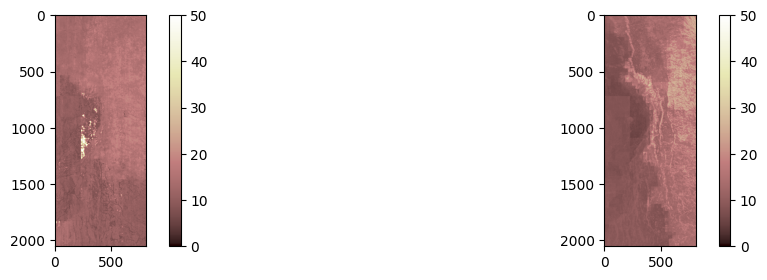

In [108]:
# Plot LSTM and RF maps
fig, (ax1, ax2) = plt.subplots(figsize=(13, 3), ncols=2)
pos = ax1.imshow(predictedLSTM_corrected, cmap='pink', vmin=0, vmax=50)
pos2 = ax2.imshow(predictedRF, cmap='pink', vmin=0, vmax=50)
fig.colorbar(pos, ax=ax1)
fig.colorbar(pos2, ax=ax2)
plt.show()

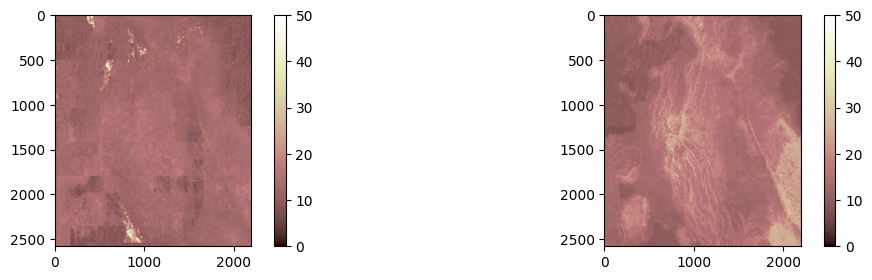

In [71]:
# Plot LSTM and RF maps
fig, (ax1, ax2) = plt.subplots(figsize=(13, 3), ncols=2)
pos = ax1.imshow(predictedLSTM_corrected, cmap='pink', vmin=0, vmax=50)
pos2 = ax2.imshow(predictedRF, cmap='pink', vmin=0, vmax=50)
fig.colorbar(pos, ax=ax1)
fig.colorbar(pos2, ax=ax2)
plt.show()

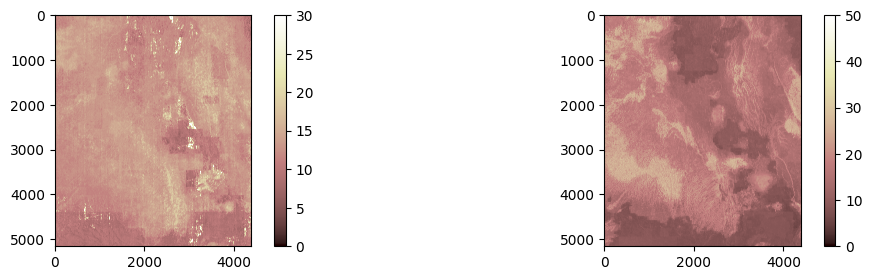

In [15]:
# Plot LSTM and RF maps
fig, (ax1, ax2) = plt.subplots(figsize=(13, 3), ncols=2)
pos = ax1.imshow(predictedLSTM_corrected, cmap='pink', vmin=0, vmax=30)
pos2 = ax2.imshow(predictedRF, cmap='pink', vmin=0, vmax=50)
fig.colorbar(pos, ax=ax1)
fig.colorbar(pos2, ax=ax2)
plt.show()